# Image Processing SS 18 - Assignment - 10

### Deadline is 27.06.2016 at 8:00 a.m. 

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.io.wavfile
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.transform import resize

from __future__ import division
import random
try:
    from StringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
    
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
    
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2
from scipy.fftpack import dct,idct
from PIL import Image
import itertools
import IPython
import zipfile
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Hadamard Matrix - 5 Points



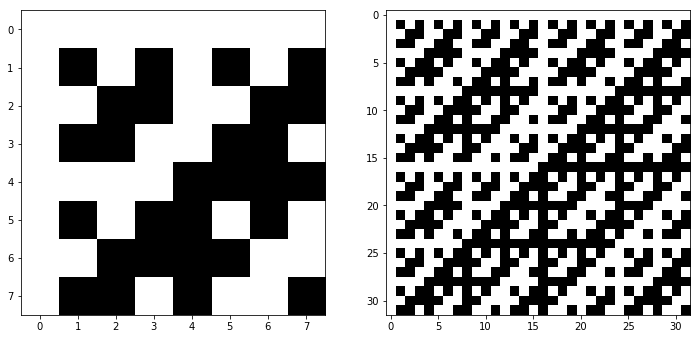

In [3]:
start = np.ones((1,1))
def _hadamard(n, matrix):
    if matrix.shape[0] == n:
        return matrix
    else:
        result = matrix.copy()
        result = np.concatenate((result, matrix), axis=1)
        result = np.concatenate(
            (
                result,
                np.concatenate((matrix, matrix * -1), axis=1),
            )
        )
        return _hadamard(n, result)

def hadamard_matrix(n):
    """Returns the Hadamard matrix. N is a power of two."""
    # your code here
    return _hadamard(n, start) / np.sqrt(n)

plt.subplot(121)
plt.imshow(hadamard_matrix(8), cmap='gray')
plt.subplot(122)
plt.imshow(hadamard_matrix(32), cmap='gray')
plt.show()

In [4]:
def get_chess_board(n=8, field_size=8):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

def get_sinus_board(n=8, field_size=8, shift=0):
    img_size = n*field_size
    linsp = np.linspace(-shift, np.pi*n - shift, img_size).reshape((img_size, 1))
    return np.dot(np.sin(linsp), np.sin(linsp.T))



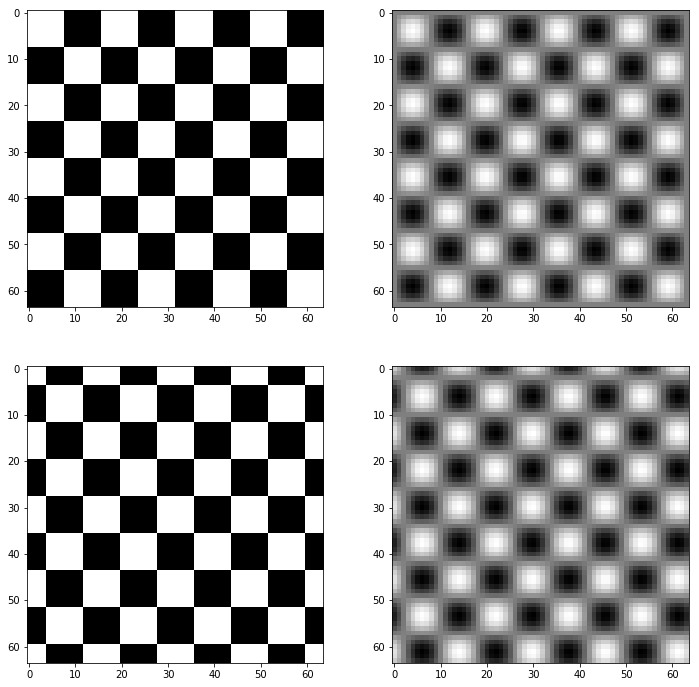

In [5]:
chess_board = get_chess_board()
chess_board_roll = np.roll(np.roll(chess_board, 4, axis=0), 4, axis=1)
sinus_board = get_sinus_board()
sinus_board_roll = get_sinus_board(shift=4)
plt.subplot(221)
plt.imshow(chess_board, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(sinus_board, cmap='gray')
plt.subplot(223)
plt.imshow(chess_board_roll, cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(sinus_board_roll, cmap='gray')
plt.show()

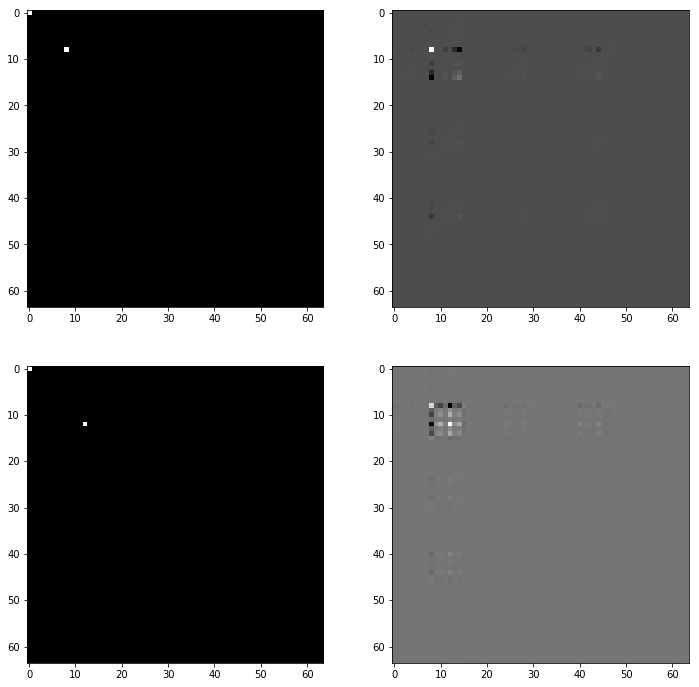

In [6]:
# Plot the 2d hadamard transformation of the chess boards and sinus boards.
# The 2D Hadamard Transformation can be computed similiar to the 2D DFT:
# H * I * H, where I is the image, H is the hadamard-matrix and * is the matrix multiplication.

H = hadamard_matrix(64)

chess_board_H = np.dot(np.dot(H, chess_board), H)                        # your code here
chess_board_roll_H = np.dot(np.dot(H, chess_board_roll), H)
sinus_board_H = np.dot(np.dot(H, sinus_board), H)
sinus_board_roll_H = np.dot(np.dot(H, sinus_board_roll), H)

plt.subplot(221)
plt.imshow(chess_board_H, cmap='gray', interpolation='nearest')
plt.subplot(222)
plt.imshow(sinus_board_H, cmap='gray')
plt.subplot(223)
plt.imshow(chess_board_roll_H, cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(sinus_board_roll_H, cmap='gray')
plt.show()

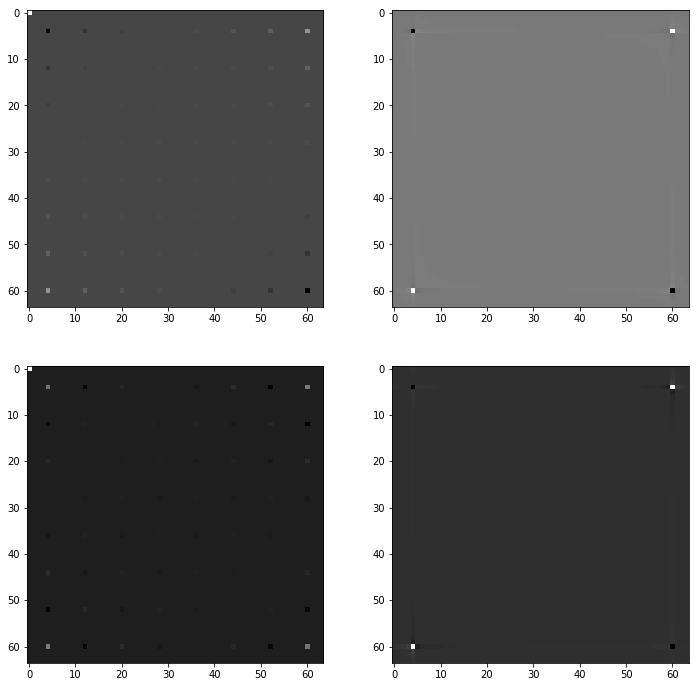

In [7]:
#plt.imshow(np.dot(np.dot(H, chess_board_roll), H))

# Plot the fourier transformation of chess boards and sinus boards. 
# You can use some functions from np.ftt
chess_board_ft = numpy_fft2(chess_board)                       # your code here
chess_board_roll_ft = numpy_fft2(chess_board_roll) 
sinus_board_ft = numpy_fft2(sinus_board)
sinus_board_roll_ft = numpy_fft2(sinus_board_roll)

plt.subplot(221)
plt.imshow(np.real(chess_board_ft), cmap='gray')#, interpolation='nearest')
plt.subplot(222)
plt.imshow(np.real(sinus_board_ft), cmap='gray')
plt.subplot(223)
plt.imshow(np.real(chess_board_roll_ft), cmap='gray', interpolation='nearest')
plt.subplot(224)
plt.imshow(np.real(sinus_board_roll_ft), cmap='gray')
plt.show()

# Exercise 2 - Compare DCT with Discrete Hadamard Transformation - 5 Points

Load the astronaut image, make sure it has a resolution of 256*256 pixels. 

Transform with :

a) DCT

b) DiskreteWalshHadamardTransf

Use different window sizes: 8x8, 32x32, 256x256. 

Erase **75 percent** of coefficents. 

Transform back into image space and calculate the average quadratic pixel error w.r.t. the original image. 

Make a table, which contains on top: DCT / DWalHadT and shows the error for WindowSize 8x8, 32x32, 256x256 
for DCT and DWalHadT respectively.

In [8]:
# understood that the deleted 75 percent could be any percent at all
# so we chose to delete in every block the lower 75 percent

img = resize(rgb2gray(astronaut()/255),(256,256))

class Blocks:
    """ From Assignment 10.
    Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size
        
    def __call__(self, img):
        b = self.block_size
        heigth, width = img.shape
        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((heigth // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, heigth // b):
            for j in range(0, heigth // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks

    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img
    
'''
img_blocks = Blocks(block_size=8)(img[:, :, 0])
print(img_blocks.shape)
assert img_blocks.shape[2:] == (8, 8)
img_inv = Blocks(block_size=8).invert(img_blocks)
assert (img[:, :, 0] == img_inv).all()
'''

def dctofblocks(blocks):
    """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficents."""
    # you can use any function from np.fft or scipy.fftpack
    # your code here
    result = np.zeros_like(blocks)
    for row in range(0,len(blocks)):
        for column in range(0,len(blocks[0])):
            result[row][column] = dct(dct(blocks[row][column].T, norm='ortho').T, norm='ortho')
    return result
    
def inv_dctofblocks(blocks):
    """Computes the inverse DCT."""
    # you can use any function from np.fft or scipy.fftpack
    # your code here
    result = np.zeros_like(blocks)
    for row in range(0,len(blocks)):
        for column in range(0,len(blocks[0])):
            blocks[row][column] = idct(idct(blocks[row][column].T, norm='ortho').T, norm='ortho')
    return blocks 

def hadofblocks(blocks):
    """Returns the DiskreteWalshHadamardTransf of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficents."""
    # you can use any function from np.fft or scipy.fftpack
    # your code here
    result = np.zeros_like(blocks)
    h = hadamard_matrix(len(blocks[0][0]))
    
    for row in range(0,len(blocks)):
        for column in range(0,len(blocks[0])):
            result[row][column] = np.dot(np.dot(h, blocks[row][column]), h)
    return result

def inv_hadofblocks(blocks):
    """Computes the inverse DiskreteWalshHadamardTransf."""
    # you can use any function from np.fft or scipy.fftpack
    # your code here
    result = np.zeros_like(blocks)
    h = hadamard_matrix(len(blocks[0][0]))
    
    for row in range(0,len(blocks)):
        for column in range(0,len(blocks[0])):
            result[row][column] = np.dot(np.dot(h, blocks[row][column]), h)

    return result

def delete75percent(blocks,blocksize):
    """Deletes 75 percent of the coefficients in each block of a picture."""
    todelete = int(np.floor(blocksize)*0.75)
    
    for row in range(0,len(blocks)):
        for column in range(0,len(blocks[0])):
            blocks[row][column][-todelete:] = np.zeros((todelete,blocksize))
    return blocks

def avgPixelError(img1, img2):
    return((img1 - img2) ** 2).mean(axis=None)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


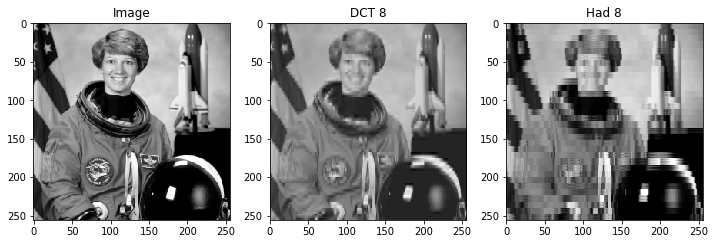

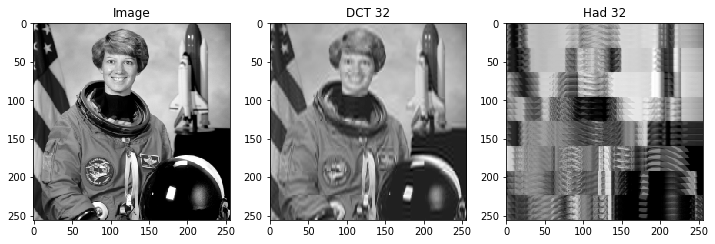

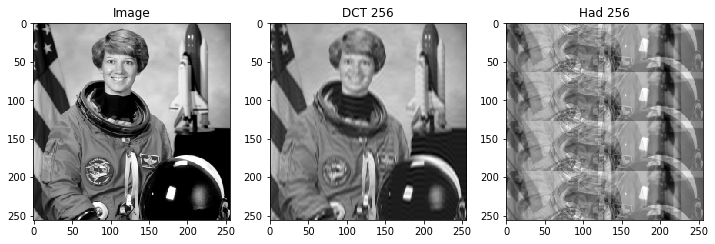

Window Size	| DCT		| DWalHadT  
		|		|	
8x8		| 0.0032380	| 0.0087186  
		|		|	
32x32		| 0.0026404	| 0.0269609  
		|		|	
256x256		| 0.0024248	| 0.0699421  
		|		|	


In [9]:
img_8blocks = Blocks(block_size=8)(img[:, :])
img_32blocks = Blocks(block_size=32)(img[:, :])
img_256blocks = Blocks(block_size=256)(img[:, :])

dct_8blocks = Blocks(block_size=8).invert(inv_dctofblocks(delete75percent(dctofblocks(img_8blocks.copy()),8)))
dct_32blocks = Blocks(block_size=32).invert(inv_dctofblocks(delete75percent(dctofblocks(img_32blocks.copy()),32)))
dct_256blocks = Blocks(block_size=256).invert(inv_dctofblocks(delete75percent(dctofblocks(img_256blocks.copy()),256)))

had_8blocks = Blocks(block_size=8).invert(inv_hadofblocks(delete75percent(hadofblocks(img_8blocks.copy()),8)))
had_32blocks = Blocks(block_size=32).invert(inv_hadofblocks(delete75percent(hadofblocks(img_32blocks.copy()),32)))
had_256blocks = Blocks(block_size=256).invert(inv_hadofblocks(delete75percent(hadofblocks(img_256blocks.copy()),256)))

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title("Image")
plt.subplot(132)
plt.imshow(dct_8blocks, cmap='gray')
plt.title("DCT 8")
plt.subplot(133)
plt.imshow(had_8blocks, cmap='gray')
plt.title("Had 8")
plt.show()

error_dct8 = avgPixelError(img, dct_8blocks)
error_had8 = avgPixelError(img, had_8blocks)

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title("Image")
plt.subplot(132)
plt.imshow(dct_32blocks, cmap='gray')
plt.title("DCT 32")
plt.subplot(133)
plt.imshow(had_32blocks, cmap='gray')
plt.title("Had 32")
plt.show()

error_dct32 = avgPixelError(img, dct_32blocks)
error_had32 = avgPixelError(img, had_32blocks)

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title("Image")
plt.subplot(132)
plt.imshow(dct_256blocks, cmap='gray')
plt.title("DCT 256")
plt.subplot(133)
plt.imshow(had_256blocks, cmap='gray')
plt.title("Had 256")
plt.show()

error_dct256 = avgPixelError(img, dct_256blocks)
error_had256 = avgPixelError(img, had_256blocks)

print("Window Size\t| DCT\t\t| DWalHadT  \n\t\t|\t\t|\t")
print("8x8\t\t| "+str(error_dct8)[0:9]+"\t| "+str(error_had8)[0:9]+"  \n\t\t|\t\t|\t")
print("32x32\t\t| "+str(error_dct32)[0:9]+"\t| "+str(error_had32)[0:9]+"  \n\t\t|\t\t|\t")
print("256x256\t\t| "+str(error_dct256)[0:9]+"\t| "+str(error_had256)[0:9]+"  \n\t\t|\t\t|\t")
